<b><font color='darkred'>
Verwenden statistischer Größen der Zeitreihen als Features
-----------------
- Power[W] &nbsp;&emsp;&emsp; ➔  Generatorleistung, Energie &emsp;➔ p
- Force[N] &emsp;&emsp;&emsp;➔  Pressenkraft &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➔ f
- Distance[mm] &nbsp;➔  Sonotrodenvorschub &emsp;&emsp;&emsp;&emsp;➔ d
- [ms] &emsp;&emsp;&emsp;&emsp;&emsp;➔  Zeit &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&emsp;&emsp;&emsp;➔ t


In [3]:
from sklearn import model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
pca = False      # PCA Anwendung ja oder nein?
n_components = 0.98

SCALE = 2000    # Skalierung für Zielvariable Zugfestigkeit


# Statistische Kennzahlen für die Modellerstellung
STATS = [
    # Power (p_*)
    "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_f_ratio", "p_d_ratio", "p_t_ratio",
    #"p_mean", "p_iqr_range", 
    
    # Force (f_*)
    "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_d_ratio", "f_t_ratio",
    #"f_mean", "f_iqr_range", 

    # Distance (d_*)
    "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_t_ratio", #"d_b75",
    #"d_mean",  "d_iqr_range", 

    # Zeitmerkmale
    "t_max",
]

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [6]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [7]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [8]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalieren Trainings- und Testdaten mit PCA

In [9]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

In [10]:
if pca == True:
    pca_scaler = PCA(n_components=n_components)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

<b><font color='lightgreen'> Kontrollanzeige t-SNE

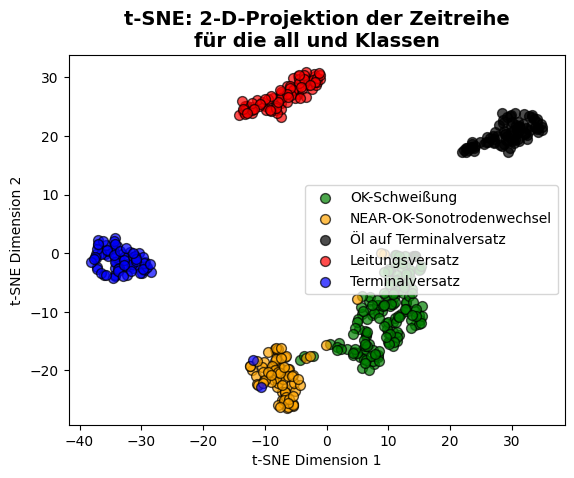

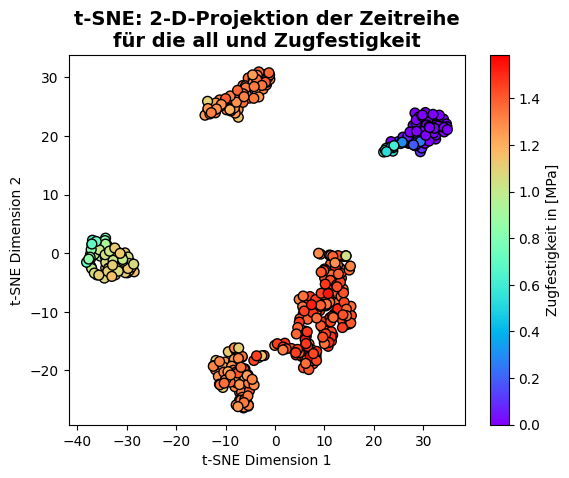

In [11]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> Random Forest Classification (Hyperparametersuche - Random Search)

In [12]:
# Hyperparameter-Space für RandomForestClassifier
rf_clf_params = {
    "n_estimators": [50, 100, 200, 500],  # Anzahl der Bäume
    "max_depth": [10, 20, 30, None],  # Maximale Tiefe der Bäume
    "min_samples_split": [2, 5, 10],  # Mindestanzahl von Samples für Split
    "min_samples_leaf": [1, 2, 4],  # Mindestanzahl von Samples in Blättern
    "max_features": ["sqrt", "log2", None],  # Anzahl der verwendeten Features pro Split
    "bootstrap": [True, False],  # Bootstrap-Sampling ja/nein
}

# RandomizedSearchCV zur Hyperparameter-Optimierung
rf_clf_search = model_selection.RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    rf_clf_params, 
    n_iter=100,  # Anzahl der getesteten Kombinationen
    scoring="accuracy", 
    cv=5, 
    n_jobs=-1, 
    random_state=42
)
rf_clf_search.fit(X_train_scaled, label_train)
best_model = rf_clf_search.best_estimator_

# Vorhersage
pred_train = best_model.predict(X_train_scaled)
pred_test  = best_model.predict(X_test_scaled)

best_model

RandomForestClassifier(max_features='log2', n_estimators=500, n_jobs=-1,
                       random_state=42)

<b><font color='lightgreen'> Modellbewertung</b>

In [13]:
helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.977     0.988        43
   near_ok_sonowechsel      0.950     1.000     0.974        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     1.000     1.000        24

              accuracy                          0.992       120
             macro avg      0.990     0.995     0.993       120
          weighted avg      0.992     0.992     0.992       120



,Train,Test
Metric,,
Accuracy,1.000,0.992
Precision,1.000,0.992
Recall,1.000,0.992
F1-score,1.000,0.992


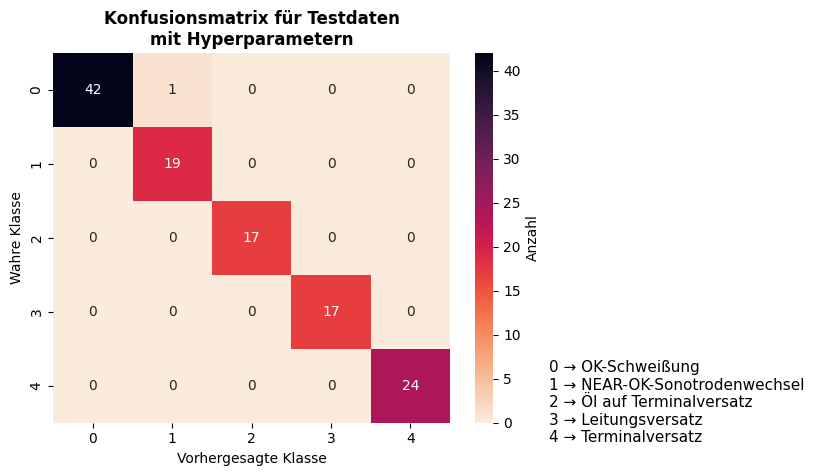

In [14]:
helper.plot_confusion(label_test, pred_test, 'Testdaten\nmit Hyperparametern')

<b><font color='lightgreen'><h3> RandomForestRegressor (Hyperparameter Random Search) </b>

In [15]:
# Hyperparameter-Space für RandomForestRegressor
rf_params = {
    "n_estimators": [50, 100, 200, 500],    # Anzahl der Bäume
    "max_depth": [10, 20, 30, None],        # Maximale Tiefe der Bäume
    "min_samples_split": [2, 5, 10],        # Mindestanzahl von Samples für Split
    "min_samples_leaf": [1, 2, 3, 4],       # Mindestanzahl von Samples in Blättern
    "max_features": ["sqrt", "log2", None], # Anzahl der verwendeten Features pro Split
    "bootstrap": [True, False],             # Bootstrap-Sampling ja/nein
}

# RandomizedSearchCV zur Hyperparameter-Optimierung
rf_search = model_selection.RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    rf_params, 
    n_iter=100,  # Anzahl der getesteten Kombinationen
    scoring="neg_mean_squared_error", 
    cv=5, 
    n_jobs=-1, 
    random_state=42
)

rf_search.fit(X_train_scaled, festigkeit_train)
best_estimator = rf_search.best_estimator_

# Vorhersage
y_pred_train = best_estimator.predict(X_train_scaled)
y_pred_test  = best_estimator.predict(X_test_scaled)

best_estimator

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

<b><font color='lightgreen'> Modellbewertung</b>

In [16]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,2814.14,16482.67
RMSE,53.05,128.38
MAE,37.59,83.08
R²,1.00,0.98


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

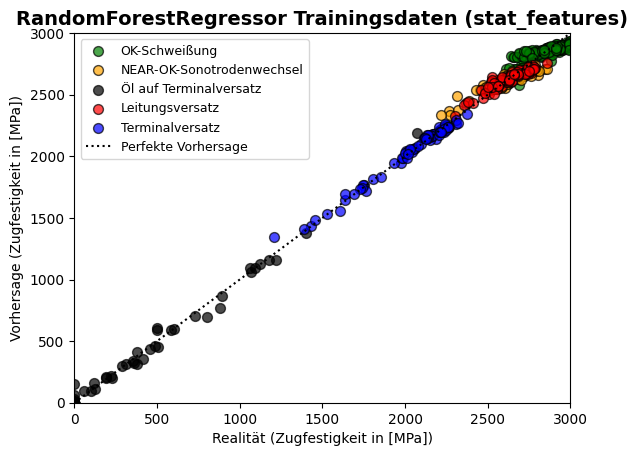

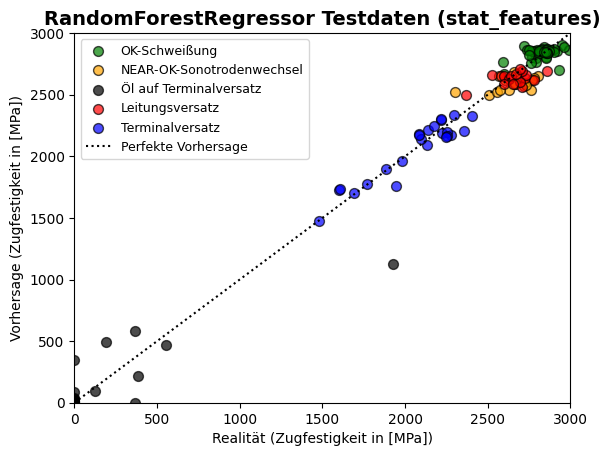

In [17]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'RandomForestRegressor Trainingsdaten (stat_features)', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'RandomForestRegressor Testdaten (stat_features)', 'mit Linie', SCALE)